In [1]:
%%capture
!pip install dowhy numpy networkx

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import dowhy
import dowhy.api
import dowhy.datasets
import dowhy.plotter
import numpy as np
import networkx as nx
from dowhy.causal_estimators.linear_regression_estimator import LinearRegressionEstimator

# The Paper of How with DoWhy

By Alessio Zanga and Fabio Stella

## Abstract

This notebook explore the "Paper of How" using the [DoWhy](https://github.com/microsoft/dowhy) package.

## Generate a Dataset

Set the random seed generator for result reproducibility.

In [4]:
np.random.seed(31)

DoWhy allows the generation of a dataset by specifying a set of parameters.

In [5]:
data = dowhy.datasets.linear_dataset(
    beta = 3,
    num_samples = int(1e4),
    num_common_causes = 0,             # No observed confounder
    num_frontdoor_variables = 1,       # Add a front-door variable
    treatment_is_binary = True,
    outcome_is_binary = False
)
list(data.keys())

['df',
 'treatment_name',
 'outcome_name',
 'common_causes_names',
 'instrument_names',
 'effect_modifier_names',
 'frontdoor_variables_names',
 'dot_graph',
 'gml_graph',
 'ate']

It will return a dictionary with a Pandas DataFrame, along with a set of variables names and the true causal graph used for the sampling process.

In [6]:
D, [X], Y, _, _, _, [M], _, G, ace = data.values()

After unpacking the values of the dictionary, it is possible to observe the assigned names to the data columns:

In [7]:
X, M, Y

('v0', 'FD0', 'y')

Graph is encoded in GML format:

In [8]:
G

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "FD0" label "FD0"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[ source "v0" target "FD0"]edge[ source "FD0" target "y"]]'

Dataset is a standard Pandas DataFrame:

In [9]:
D

,FD0,v0,y
0,-0.511649,True,-0.649035
1,-0.742863,False,-0.929083
2,-0.127294,False,-0.157401
3,0.800696,True,0.993552
4,-0.435988,False,-0.565250
...,...,...,...
9995,2.927993,True,3.714110
9996,0.890986,True,1.128931
9997,0.937298,True,1.193908
9998,1.038223,True,1.323971


It also return the true average causal effect:

In [10]:
ace

## Construct a Model

The second step consists in constructing a causal model using the true graph.

In [11]:
model = dowhy.CausalModel(
    data = D,
    treatment = X,
    outcome = Y,
    graph = G
)

It is not a proper SCM as we seen in previous sessions. It is more like a container for the data and the graph.

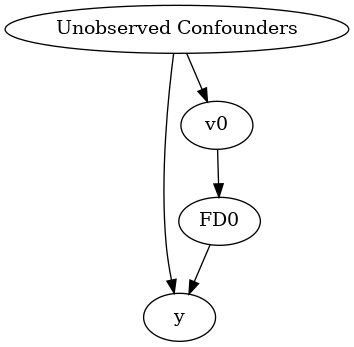

In [12]:
model.view_model(layout="dot")
# from IPython.display import Image, display    # Run these lines if you are on local.
# display(Image(filename="causal_model.png"))

This will enable the identification step by using a couple of handful methods.

## Identify the Estimand

The estimand identification tests for both backdoor and frontdoor criterion.

In [13]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                  
─────(Expectation(y))
d[v₀]                
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,,U) = P(y|v0,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(y, [FD0])*Derivative([FD0], [v0]))
Estimand assumption 1, Full-mediation: FD0 intercepts (blocks) all directed paths from v0 to y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)



## Estimate the Average Causal Effect

Once the estimand has been identified, we can proceed to the last estimation step.

The front-door criterion employs a two-stage (linear, in this example) estimator:

First stage estimator: $$M = \alpha \cdot X + \beta$$
Second stage estimator: $$Y = \gamma \cdot M + \delta \cdot X + \epsilon$$

In [14]:
estimate = model.estimate_effect(
    estimand,
    method_name = "frontdoor.two_stage_regression",
    method_params = {
        "first_stage_model": LinearRegressionEstimator,
        "second_stage_model": LinearRegressionEstimator
    }
)

In [15]:
print(f"""
Estimation Method: TwoStageRegression,
Estimated ACE: {estimate.value:.4},
Relative Error: {(abs((estimate.value-ace)/ace*100)):.4}%
""".lstrip("\n"))

Estimation Method: TwoStageRegression,
Estimated ACE: 1.775,
Relative Error: 1.375%



## Evaluate the Results

With the estimates obtained we can setup a round of hypothesis testing.

In [16]:
refuters = [
    "bootstrap_refuter",
    "data_subset_refuter",
    # NOTE: Not implemented for front-door yet.
    # "dummy_outcome_refuter",
    # "placebo_treatment_refuter",
    # "random_common_cause",
]

We will test against the estimate.

In [17]:
refuters = {
    refuter: model.refute_estimate(estimand, estimate, method_name=refuter)
    for refuter in refuters
}

Some "refuters", as they are called in DoWhy, may return a list of tests.

In [18]:
for refuter in refuters.values():
    print(refuter if type(refuter) != list else refuter[0])

Refute: Bootstrap Sample Dataset
Estimated effect:1.7752106198030266
New effect:1.7738055406149422
p value:0.47

Refute: Use a subset of data
Estimated effect:1.7752106198030266
New effect:1.7733230087592196
p value:0.44999999999999996



Your results may vary. Try to experiment with different graph configurations by altering the numbers of variables in the generation step.

Have fun!